This daily forecasting was done using a Kaggle notebook. However, you can easily replicate this notebbook in any IDE. 
If not running this in Kaggle Notebook, please dont run below line

In [1]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv
/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv
/kaggle/input/rohlik-orders-forecasting-challenge/train.csv
/kaggle/input/rohlik-orders-forecasting-challenge/test.csv
/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv


Importing Libraries required

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
!pip install statsforecast --upgrade
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from statsforecast import StatsForecast
from statsforecast.feature_engineering import mstl_decomposition
from statsforecast.models import MSTL, AutoARIMA
import plotly.express as px

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import smape, mase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 5.7 MB/s eta 0:00:00


In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from learntools.time_series.utils import plot_periodogram, seasonal_plot # For understanding the seasonality component in the data

You can just give the path of the input files instead of path mentioned in below line

In [5]:
train_df = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv')
test_df = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv')
train_calendar = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv')
test_calendar = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv')

In [6]:
train_df.tail(5)

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
7335,Budapest_1,2024-03-10,6733.0,NaN,0,0,0,0,0,0,0,0.0,0,1.51,0.0,2983.0,27111.0,Budapest_1_2024-03-10
7336,Budapest_1,2024-03-11,6492.0,NaN,0,0,0,0,0,0,0,0.0,0,1.03,0.0,2975.0,27133.0,Budapest_1_2024-03-11
7337,Budapest_1,2024-03-12,6661.0,NaN,0,0,0,0,0,0,0,0.0,0,0.21,0.0,2974.0,27151.0,Budapest_1_2024-03-12
7338,Budapest_1,2024-03-13,6843.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,2979.0,27180.0,Budapest_1_2024-03-13
7339,Budapest_1,2024-03-14,8130.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,2953.0,27231.0,Budapest_1_2024-03-14


# **EDA - Understanding the data**

In [8]:
test_calendar[test_calendar['warehouse']=='Budapest_1']

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
340,Budapest_1,2024-03-16,NaN,0,0,0,0,Budapest_1_2024-03-16
341,Budapest_1,2024-03-17,NaN,0,0,0,0,Budapest_1_2024-03-17
342,Budapest_1,2024-03-18,NaN,0,0,0,0,Budapest_1_2024-03-18
343,Budapest_1,2024-03-19,NaN,0,0,0,0,Budapest_1_2024-03-19
344,Budapest_1,2024-03-20,NaN,0,0,0,0,Budapest_1_2024-03-20
345,Budapest_1,2024-03-21,NaN,0,0,0,0,Budapest_1_2024-03-21
346,Budapest_1,2024-03-22,NaN,0,0,0,0,Budapest_1_2024-03-22
347,Budapest_1,2024-03-23,NaN,0,0,0,0,Budapest_1_2024-03-23
348,Budapest_1,2024-03-24,NaN,0,0,0,0,Budapest_1_2024-03-24
349,Budapest_1,2024-03-25,NaN,0,0,0,0,Budapest_1_2024-03-25


In [9]:
test_calendar.columns

Index(['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')

In [10]:
test_df.columns

Index(['date', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'warehouse'],
      dtype='object')

In [11]:
train_df

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.80,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.50,0.0,1704.0,32410.0,Prague_1_2020-12-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,Budapest_1,2024-03-10,6733.0,NaN,0,0,0,0,0,0,0,0.0,0,1.51,0.0,2983.0,27111.0,Budapest_1_2024-03-10
7336,Budapest_1,2024-03-11,6492.0,NaN,0,0,0,0,0,0,0,0.0,0,1.03,0.0,2975.0,27133.0,Budapest_1_2024-03-11
7337,Budapest_1,2024-03-12,6661.0,NaN,0,0,0,0,0,0,0,0.0,0,0.21,0.0,2974.0,27151.0,Budapest_1_2024-03-12
7338,Budapest_1,2024-03-13,6843.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,2979.0,27180.0,Budapest_1_2024-03-13


In [12]:
train_df['warehouse'].unique()

array(['Prague_1', 'Brno_1', 'Prague_2', 'Prague_3', 'Munich_1',
       'Frankfurt_1', 'Budapest_1'], dtype=object)

Total 7 Unique warehouses are there, whose forecast needs to be predicted.

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7340 non-null   object 
 1   date                    7340 non-null   object 
 2   orders                  7340 non-null   float64
 3   holiday_name            218 non-null    object 
 4   holiday                 7340 non-null   int64  
 5   shutdown                7340 non-null   int64  
 6   mini_shutdown           7340 non-null   int64  
 7   shops_closed            7340 non-null   int64  
 8   winter_school_holidays  7340 non-null   int64  
 9   school_holidays         7340 non-null   int64  
 10  blackout                7340 non-null   int64  
 11  mov_change              7340 non-null   float64
 12  frankfurt_shutdown      7340 non-null   int64  
 13  precipitation           7070 non-null   float64
 14  snow                    7070 non-null   

In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   date                    1869 non-null   object
 1   holiday_name            69 non-null     object
 2   holiday                 1869 non-null   int64 
 3   shops_closed            1869 non-null   int64 
 4   winter_school_holidays  1869 non-null   int64 
 5   school_holidays         1869 non-null   int64 
 6   warehouse               1869 non-null   object
dtypes: int64(4), object(3)
memory usage: 102.3+ KB


In [15]:
train_df.rename(columns = {'warehouse':'unique_id', 'date':'ds', 'orders':'y'}, inplace=True)
train_df['ds'] = pd.to_datetime(train_df['ds'])
train_df

,unique_id,ds,y,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.80,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.50,0.0,1704.0,32410.0,Prague_1_2020-12-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,Budapest_1,2024-03-10,6733.0,NaN,0,0,0,0,0,0,0,0.0,0,1.51,0.0,2983.0,27111.0,Budapest_1_2024-03-10
7336,Budapest_1,2024-03-11,6492.0,NaN,0,0,0,0,0,0,0,0.0,0,1.03,0.0,2975.0,27133.0,Budapest_1_2024-03-11
7337,Budapest_1,2024-03-12,6661.0,NaN,0,0,0,0,0,0,0,0.0,0,0.21,0.0,2974.0,27151.0,Budapest_1_2024-03-12
7338,Budapest_1,2024-03-13,6843.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,2979.0,27180.0,Budapest_1_2024-03-13


In [16]:
StatsForecast.plot(train_df, engine = 'plotly',unique_ids= ['Prague_1'])

In [17]:
StatsForecast.plot(train_df, engine = 'plotly')

An interesting observation that can be made is that warehouse of same country(Prague) have a very similar behaviour. Also in few country warehouses, orders are following a more uptrend than onthers.So, the sales vary based on region significantly. We can use the same factor while modelling them if needed

In [19]:
# extract the desired datetime components
train_df['year'] = train_df['ds'].dt.year
train_df['month'] = train_df['ds'].dt.month
train_df['day'] = train_df['ds'].dt.day
train_df['day_of_week'] = train_df['ds'].dt.weekday
train_df['week_of_year'] = train_df['ds'].dt.isocalendar().week

In [20]:
train_df

,unique_id,ds,y,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,...,precipitation,snow,user_activity_1,user_activity_2,id,year,month,day,day_of_week,week_of_year
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,...,0.00,0.0,1722.0,32575.0,Prague_1_2020-12-05,2020,12,5,5,49
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,...,0.00,0.0,1688.0,32507.0,Prague_1_2020-12-06,2020,12,6,6,49
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,...,0.00,0.0,1696.0,32552.0,Prague_1_2020-12-07,2020,12,7,0,50
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,...,0.80,0.0,1681.0,32423.0,Prague_1_2020-12-08,2020,12,8,1,50
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,...,0.50,0.0,1704.0,32410.0,Prague_1_2020-12-09,2020,12,9,2,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,Budapest_1,2024-03-10,6733.0,NaN,0,0,0,0,0,0,...,1.51,0.0,2983.0,27111.0,Budapest_1_2024-03-10,2024,3,10,6,10
7336,Budapest_1,2024-03-11,6492.0,NaN,0,0,0,0,0,0,...,1.03,0.0,2975.0,27133.0,Budapest_1_2024-03-11,2024,3,11,0,11
7337,Budapest_1,2024-03-12,6661.0,NaN,0,0,0,0,0,0,...,0.21,0.0,2974.0,27151.0,Budapest_1_2024-03-12,2024,3,12,1,11
7338,Budapest_1,2024-03-13,6843.0,NaN,0,0,0,0,0,0,...,0.00,0.0,2979.0,27180.0,Budapest_1_2024-03-13,2024,3,13,2,11


<Axes: title={'center': 'Seasonal Plot (month/day_of_week)'}, xlabel='day_of_week', ylabel='y'>

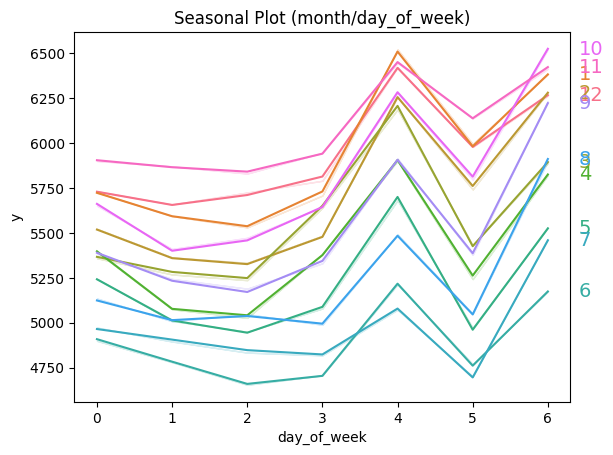

In [21]:
# Seasonal_plot runs only in kaggle Notebooks, if you want to analyse data in similar sense in any other platform use groupby & matplot commands
# together to achieve the same
seasonal_plot(train_df, y='y', period='month', freq='day_of_week')

**It is clear that irrespective of month, day of week has high influence on sales. Sales on 4 & 6 which are Friday & Sunday respectively are usually high**

<Axes: title={'center': 'Seasonal Plot (month/day)'}, xlabel='day', ylabel='y'>

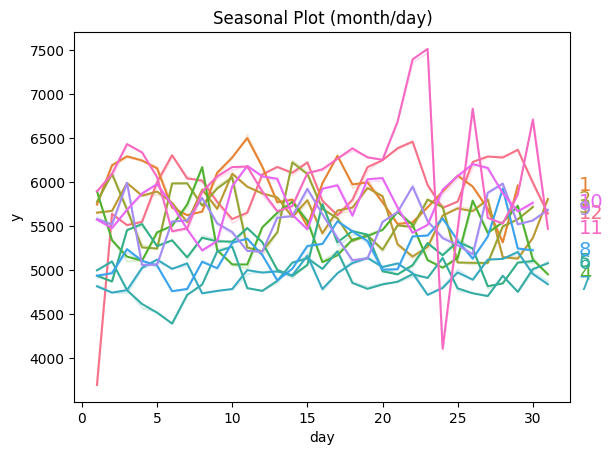

In [22]:
seasonal_plot(train_df, y='y', period='month', freq='day')

**Pattern of varaition wrt days within a month is not very clear**

<Axes: title={'center': 'Seasonal Plot (year/month)'}, xlabel='month', ylabel='y'>

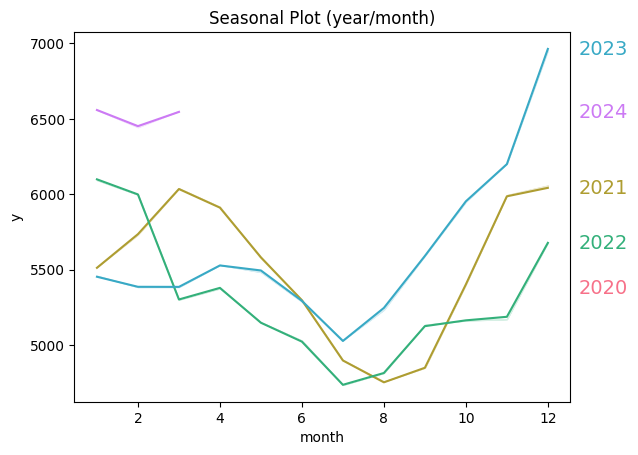

In [25]:
seasonal_plot(train_df, y='y', period='year', freq='month')

**There is a clear seasonality wrt Months, Months July & Aug are of low demand every year, high in Nov to Jan with peaks hitting typically in December**

Now, lets analyse the relationship between No. of orders & external variables like holidays & others..

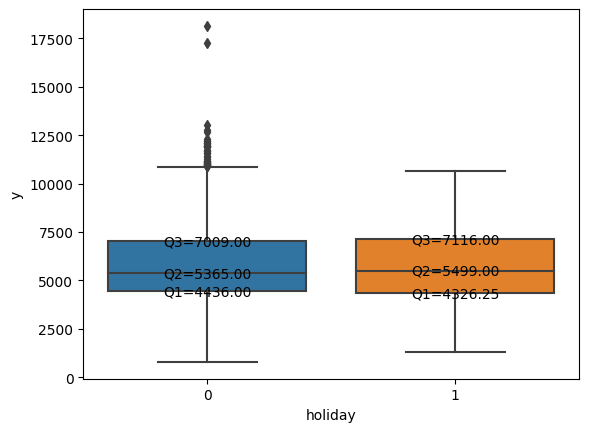

In [26]:
sns.boxplot(data = train_df,x ='holiday', y = 'y')

# Calculate quartiles
quartiles = train_df.groupby('holiday')['y'].quantile([0.25, 0.5, 0.75]).unstack()

# Annotate the quartiles
for holiday in [0, 1]:
    Q1 = quartiles.loc[holiday, 0.25]
    Q2 = quartiles.loc[holiday, 0.5]
    Q3 = quartiles.loc[holiday, 0.75]
    
    plt.text(holiday, Q1, f'Q1={Q1:.2f}', ha='center', va='center', color='black', fontsize=10, )
    plt.text(holiday, Q2, f'Q2={Q2:.2f}', ha='center', va='center', color='black', fontsize=10, )
    plt.text(holiday, Q3, f'Q3={Q3:.2f}', ha='center', va='center', color='black', fontsize=10,)

plt.show()

**Interestingly, at an overall level, there is no much difference between holidays & no holidays, overall orders is more/less same**

Let me check if there is any country dependence on the holidays

<Axes: xlabel='holiday', ylabel='y'>

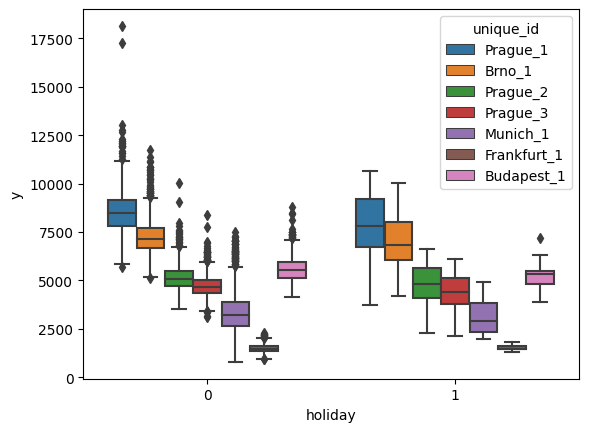

In [27]:
sns.boxplot(data = train_df,x ='holiday', y = 'y', hue = 'unique_id')

Even at a country level, there seems to be no major change wrt Median orders(Q2) , however Q1-Q3 range seems to be increasing, indicating more larger variance in the order numbers during holidays

Now, lets try to understand how orders no. vary wrt different holidays

In [28]:
train_df['holiday_name'].nunique()

24

<Axes: xlabel='y', ylabel='holiday_name'>

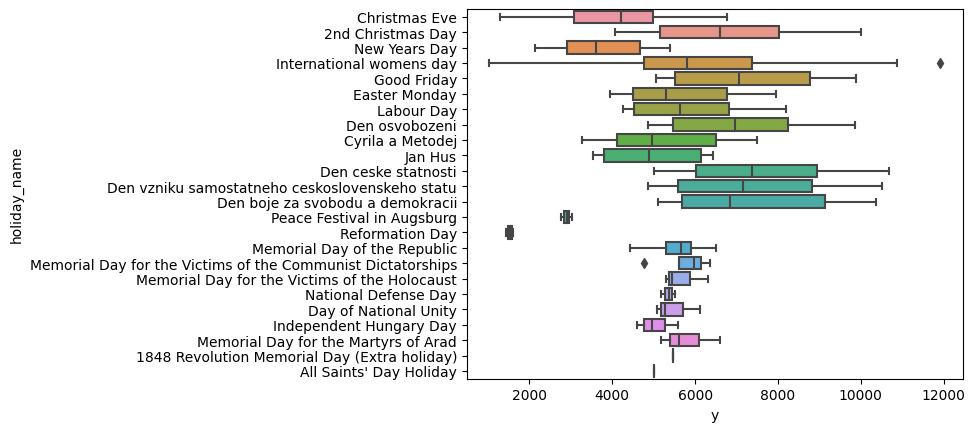

In [29]:
sns.boxplot(data = train_df,x ='y', y = 'holiday_name',orient = "h")

It is clear that certain holidays like Good Friday, 2nd Christmas day etc have huge impact on the demand compared to other holidays

Lets  try to understand impact of school holidays

<Axes: xlabel='school_holidays', ylabel='y'>

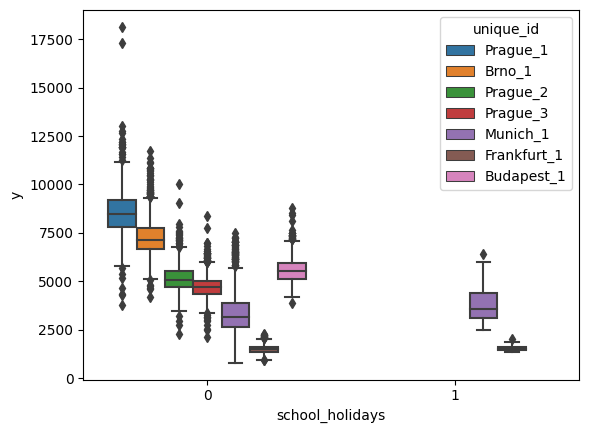

In [30]:
sns.boxplot(data = train_df,x ='school_holidays', y = 'y', hue = 'unique_id')

Only Frankfurt & Budapest have school_holidays data , that impact also looks minimal

In [31]:
train_df[train_df['unique_id']=='Frankfurt_1']

,unique_id,ds,y,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,...,precipitation,snow,user_activity_1,user_activity_2,id,year,month,day,day_of_week,week_of_year
5557,Frankfurt_1,2022-02-18,929.0,NaN,0,0,0,0,0,0,...,0.00,0.0,899.0,2691.0,Frankfurt_1_2022-02-18,2022,2,18,4,7
5558,Frankfurt_1,2022-02-19,931.0,NaN,0,0,0,0,0,0,...,0.00,0.0,900.0,2747.0,Frankfurt_1_2022-02-19,2022,2,19,5,7
5559,Frankfurt_1,2022-02-23,945.0,NaN,0,0,0,0,0,0,...,0.00,0.0,897.0,2885.0,Frankfurt_1_2022-02-23,2022,2,23,2,8
5560,Frankfurt_1,2022-02-24,955.0,NaN,0,0,0,0,0,0,...,0.00,0.0,897.0,2940.0,Frankfurt_1_2022-02-24,2022,2,24,3,8
5561,Frankfurt_1,2022-02-25,1022.0,NaN,0,0,0,0,0,0,...,0.00,0.0,955.0,3024.0,Frankfurt_1_2022-02-25,2022,2,25,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6181,Frankfurt_1,2024-03-11,1867.0,NaN,0,0,0,0,0,0,...,13.13,0.0,828.0,7177.0,Frankfurt_1_2024-03-11,2024,3,11,0,11
6182,Frankfurt_1,2024-03-12,1629.0,NaN,0,0,0,0,0,0,...,3.12,0.0,820.0,7240.0,Frankfurt_1_2024-03-12,2024,3,12,1,11
6183,Frankfurt_1,2024-03-13,1552.0,NaN,0,0,0,0,0,0,...,1.01,0.0,817.0,7227.0,Frankfurt_1_2024-03-13,2024,3,13,2,11
6184,Frankfurt_1,2024-03-14,1608.0,NaN,0,0,0,0,0,0,...,0.00,0.0,812.0,7230.0,Frankfurt_1_2024-03-14,2024,3,14,3,11


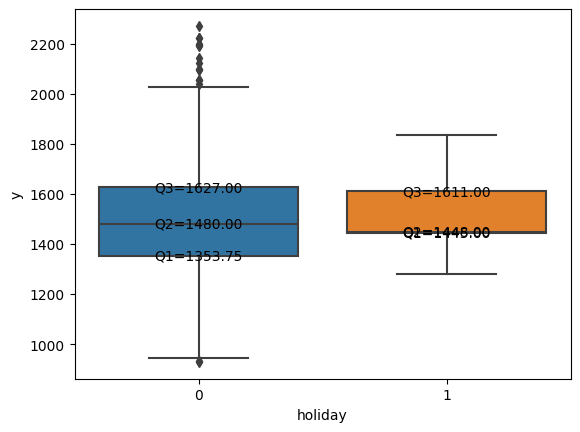

In [32]:
sns.boxplot(data = train_df[train_df['unique_id']=='Frankfurt_1'],x ='holiday', y = 'y')

# Calculate quartiles
quartiles = train_df[train_df['unique_id']=='Frankfurt_1'].groupby('holiday')['y'].quantile([0.25, 0.5, 0.75]).unstack()

# Annotate the quartiles
for holiday in [0, 1]:
    Q1 = quartiles.loc[holiday, 0.25]
    Q2 = quartiles.loc[holiday, 0.5]
    Q3 = quartiles.loc[holiday, 0.75]
    
    plt.text(holiday, Q1, f'Q1={Q1:.2f}', ha='center', va='center', color='black', fontsize=10, )
    plt.text(holiday, Q2, f'Q2={Q2:.2f}', ha='center', va='center', color='black', fontsize=10, )
    plt.text(holiday, Q3, f'Q3={Q3:.2f}', ha='center', va='center', color='black', fontsize=10,)

plt.show()

In [33]:
test_df.head(2)

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2024-11-17,Den boje za svobodu a demokracii,1,0,0,0,Prague_1
1,2024-07-04,NaN,0,0,0,0,Prague_1


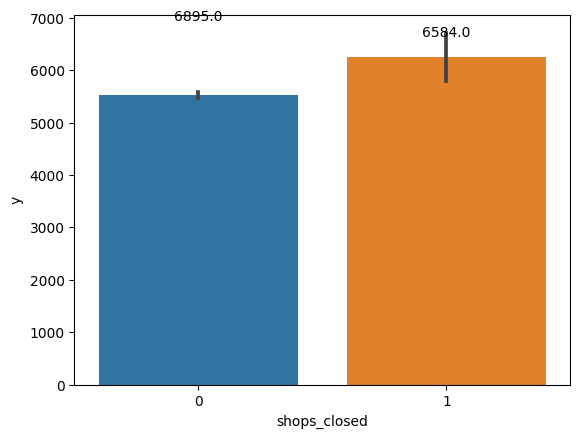

In [34]:
sns.barplot(data = train_df,x ='shops_closed', y = 'y')
# Display the value of each bar
for i, value in enumerate(train_df['y']):
    plt.annotate(str(value), (i, value), ha='center', va='bottom')
    
plt.show()

There is a clear more no. of sales when shops are closed. This is expected as people may order more when through online when shops are closed. 

# create a lag feature with a lag of 1 day

In [35]:
grouped_df = train_df.groupby("unique_id")

In [36]:
k=pd.DataFrame()
for unique_id, group in grouped_df:
    group['shops_closed_lag'] = group['shops_closed'].shift()
    group.reset_index(inplace=True)
    k = pd.concat([k,group])

In [37]:
k.drop("index", axis = 1, inplace = True)

In [38]:
train_df = k 

In [39]:
train_df.shape

(7340, 24)

In [40]:
train_df.head()

,unique_id,ds,y,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,...,snow,user_activity_1,user_activity_2,id,year,month,day,day_of_week,week_of_year,shops_closed_lag
0,Brno_1,2020-12-05,6447.0,NaN,0,0,0,0,0,0,...,0.0,2332.0,27392.0,Brno_1_2020-12-05,2020,12,5,5,49,NaN
1,Brno_1,2020-12-06,5338.0,NaN,0,0,0,0,0,0,...,0.0,2294.0,27305.0,Brno_1_2020-12-06,2020,12,6,6,49,0.0
2,Brno_1,2020-12-07,5621.0,NaN,0,0,0,0,0,0,...,0.0,2305.0,27255.0,Brno_1_2020-12-07,2020,12,7,0,50,0.0
3,Brno_1,2020-12-08,5792.0,NaN,0,0,0,0,0,0,...,0.0,2321.0,27120.0,Brno_1_2020-12-08,2020,12,8,1,50,0.0
4,Brno_1,2020-12-09,5894.0,NaN,0,0,0,0,0,0,...,0.0,2331.0,27209.0,Brno_1_2020-12-09,2020,12,9,2,50,0.0


Now, let us try to understand what happens when the shops are closed  & next day when shops open to online orders. Is it different from normal days or not..

In [41]:
train_df.columns

Index(['unique_id', 'ds', 'y', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id',
       'year', 'month', 'day', 'day_of_week', 'week_of_year',
       'shops_closed_lag'],
      dtype='object')

In [42]:
# Dropping null value rows of train_df lag feature rows
train_df = train_df[train_df['shops_closed_lag'].notna()]

In [43]:
train_df.shape

(7333, 24)

In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7333 entries, 1 to 1192
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   unique_id               7333 non-null   object        
 1   ds                      7333 non-null   datetime64[ns]
 2   y                       7333 non-null   float64       
 3   holiday_name            218 non-null    object        
 4   holiday                 7333 non-null   int64         
 5   shutdown                7333 non-null   int64         
 6   mini_shutdown           7333 non-null   int64         
 7   shops_closed            7333 non-null   int64         
 8   winter_school_holidays  7333 non-null   int64         
 9   school_holidays         7333 non-null   int64         
 10  blackout                7333 non-null   int64         
 11  mov_change              7333 non-null   float64       
 12  frankfurt_shutdown      7333 non-null   int64        

In [45]:
train_df['Shop_opened_after_close'] = train_df.apply(lambda x : 1 if( x['shops_closed'] == 0 and x['shops_closed_lag'] == 1) else 0, axis =1)

In [46]:
train_df.head(1)

,unique_id,ds,y,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,...,user_activity_1,user_activity_2,id,year,month,day,day_of_week,week_of_year,shops_closed_lag,Shop_opened_after_close
1,Brno_1,2020-12-06,5338.0,NaN,0,0,0,0,0,0,...,2294.0,27305.0,Brno_1_2020-12-06,2020,12,6,6,49,0.0,0


In [47]:
train_df.tail(5)

,unique_id,ds,y,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,...,user_activity_1,user_activity_2,id,year,month,day,day_of_week,week_of_year,shops_closed_lag,Shop_opened_after_close
1188,Prague_3,2024-03-11,5208.0,NaN,0,0,0,0,0,0,...,950.0,22163.0,Prague_3_2024-03-11,2024,3,11,0,11,0.0,0
1189,Prague_3,2024-03-12,5116.0,NaN,0,0,0,0,0,0,...,943.0,22096.0,Prague_3_2024-03-12,2024,3,12,1,11,0.0,0
1190,Prague_3,2024-03-13,4980.0,NaN,0,0,0,0,0,0,...,949.0,22088.0,Prague_3_2024-03-13,2024,3,13,2,11,0.0,0
1191,Prague_3,2024-03-14,5208.0,NaN,0,0,0,0,0,0,...,941.0,22068.0,Prague_3_2024-03-14,2024,3,14,3,11,0.0,0
1192,Prague_3,2024-03-15,6408.0,NaN,0,0,0,0,0,0,...,955.0,22037.0,Prague_3_2024-03-15,2024,3,15,4,11,0.0,0


<Axes: xlabel='Shop_opened_after_close', ylabel='y'>

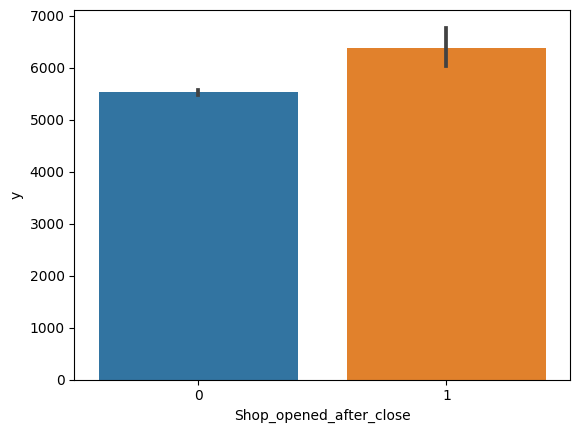

In [48]:
sns.barplot(data = train_df,x ='Shop_opened_after_close', y = 'y')

In [49]:
train_df.groupby('shops_closed')['y'].mean()

shops_closed
0    5528.901282
1    6259.487500
Name: y, dtype: float64

In [50]:
train_df.groupby('Shop_opened_after_close')['y'].mean()

Shop_opened_after_close
0    5527.501448
1    6386.400000
Name: y, dtype: float64

The difference of online orders is even higher between shops are immediately opened after holiday & otherwise looks significant. So btr to use lag features of the this particular external regressor(Shop closed)

In [51]:
train_df.groupby('winter_school_holidays')['y'].mean()

winter_school_holidays
0    5507.264727
1    6494.118182
Name: y, dtype: float64

 # **Modelling**

We will not extract the month columns & create dummy columns to model monthly seasonality.. Bcs Tree based models can handle it
We will not extract the weekdays & create dummy columns to model daily seasonality..Bcs Tree based models can handle it

In [52]:
#test_df.info()

In [53]:
#test_df['date'] = pd.to_datetime(test_df['date'])

In [54]:
train_df.columns

Index(['unique_id', 'ds', 'y', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id',
       'year', 'month', 'day', 'day_of_week', 'week_of_year',
       'shops_closed_lag', 'Shop_opened_after_close'],
      dtype='object')

In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7333 entries, 1 to 1192
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unique_id                7333 non-null   object        
 1   ds                       7333 non-null   datetime64[ns]
 2   y                        7333 non-null   float64       
 3   holiday_name             218 non-null    object        
 4   holiday                  7333 non-null   int64         
 5   shutdown                 7333 non-null   int64         
 6   mini_shutdown            7333 non-null   int64         
 7   shops_closed             7333 non-null   int64         
 8   winter_school_holidays   7333 non-null   int64         
 9   school_holidays          7333 non-null   int64         
 10  blackout                 7333 non-null   int64         
 11  mov_change               7333 non-null   float64       
 12  frankfurt_shutdown       7333 non-null 

Checking the daily forecast accuracy over next 60 days

In [56]:
test_df = train_df[(train_df['ds'] > '2024-01-15')]

In [57]:
test_df

,unique_id,ds,y,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,...,user_activity_1,user_activity_2,id,year,month,day,day_of_week,week_of_year,shops_closed_lag,Shop_opened_after_close
1133,Brno_1,2024-01-16,8941.0,NaN,0,0,0,0,0,0,...,2360.0,39093.0,Brno_1_2024-01-16,2024,1,16,1,3,0.0,0
1134,Brno_1,2024-01-17,8560.0,NaN,0,0,0,0,0,0,...,2343.0,39027.0,Brno_1_2024-01-17,2024,1,17,2,3,0.0,0
1135,Brno_1,2024-01-18,9095.0,NaN,0,0,0,0,0,0,...,2381.0,38849.0,Brno_1_2024-01-18,2024,1,18,3,3,0.0,0
1136,Brno_1,2024-01-19,10723.0,NaN,0,0,0,0,0,0,...,2389.0,38691.0,Brno_1_2024-01-19,2024,1,19,4,3,0.0,0
1137,Brno_1,2024-01-20,9512.0,NaN,0,0,0,0,0,0,...,2377.0,38411.0,Brno_1_2024-01-20,2024,1,20,5,3,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,Prague_3,2024-03-11,5208.0,NaN,0,0,0,0,0,0,...,950.0,22163.0,Prague_3_2024-03-11,2024,3,11,0,11,0.0,0
1189,Prague_3,2024-03-12,5116.0,NaN,0,0,0,0,0,0,...,943.0,22096.0,Prague_3_2024-03-12,2024,3,12,1,11,0.0,0
1190,Prague_3,2024-03-13,4980.0,NaN,0,0,0,0,0,0,...,949.0,22088.0,Prague_3_2024-03-13,2024,3,13,2,11,0.0,0
1191,Prague_3,2024-03-14,5208.0,NaN,0,0,0,0,0,0,...,941.0,22068.0,Prague_3_2024-03-14,2024,3,14,3,11,0.0,0


In [58]:
train_df = train_df[(train_df['ds'] <= '2024-01-15')]

In [59]:
train_df.columns

Index(['unique_id', 'ds', 'y', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id',
       'year', 'month', 'day', 'day_of_week', 'week_of_year',
       'shops_closed_lag', 'Shop_opened_after_close'],
      dtype='object')

In [60]:
Drop_columns = ['shutdown','mini_shutdown', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2','id','holiday_name']

In [61]:
train_df = train_df.drop(Drop_columns, axis = 1)

In [62]:
test_df = test_df.drop(Drop_columns, axis = 1 )

In [63]:
train_df.columns

Index(['unique_id', 'ds', 'y', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'shops_closed_lag',
       'Shop_opened_after_close'],
      dtype='object')

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6930 entries, 1 to 1132
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unique_id                6930 non-null   object        
 1   ds                       6930 non-null   datetime64[ns]
 2   y                        6930 non-null   float64       
 3   holiday                  6930 non-null   int64         
 4   shops_closed             6930 non-null   int64         
 5   winter_school_holidays   6930 non-null   int64         
 6   school_holidays          6930 non-null   int64         
 7   year                     6930 non-null   int32         
 8   month                    6930 non-null   int32         
 9   day                      6930 non-null   int32         
 10  day_of_week              6930 non-null   int32         
 11  week_of_year             6930 non-null   UInt32        
 12  shops_closed_lag         6930 non-null 

In [65]:
# train_df['holiday_name'] = np.where((train_df['holiday_name'].isna()) & (train_df['holiday'] == 1), 'Some Holiday', train_df['holiday_name'])

In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6930 entries, 1 to 1132
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unique_id                6930 non-null   object        
 1   ds                       6930 non-null   datetime64[ns]
 2   y                        6930 non-null   float64       
 3   holiday                  6930 non-null   int64         
 4   shops_closed             6930 non-null   int64         
 5   winter_school_holidays   6930 non-null   int64         
 6   school_holidays          6930 non-null   int64         
 7   year                     6930 non-null   int32         
 8   month                    6930 non-null   int32         
 9   day                      6930 non-null   int32         
 10  day_of_week              6930 non-null   int32         
 11  week_of_year             6930 non-null   UInt32        
 12  shops_closed_lag         6930 non-null 

In [67]:
# test_df['holiday_name'] = np.where((test_df['holiday_name'].isna()) & (test_df['holiday'] == 1), 'Some Holiday', test_df['holiday_name'])

In [68]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 403 entries, 1133 to 1192
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unique_id                403 non-null    object        
 1   ds                       403 non-null    datetime64[ns]
 2   y                        403 non-null    float64       
 3   holiday                  403 non-null    int64         
 4   shops_closed             403 non-null    int64         
 5   winter_school_holidays   403 non-null    int64         
 6   school_holidays          403 non-null    int64         
 7   year                     403 non-null    int32         
 8   month                    403 non-null    int32         
 9   day                      403 non-null    int32         
 10  day_of_week              403 non-null    int32         
 11  week_of_year             403 non-null    UInt32        
 12  shops_closed_lag         403 non-null

In [69]:
test_df1 = test_df.copy()

In [70]:
test_df1.drop('y',axis = 1,inplace = True)

In [71]:
test_df1.head()

,unique_id,ds,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,day_of_week,week_of_year,shops_closed_lag,Shop_opened_after_close
1133,Brno_1,2024-01-16,0,0,0,0,2024,1,16,1,3,0.0,0
1134,Brno_1,2024-01-17,0,0,0,0,2024,1,17,2,3,0.0,0
1135,Brno_1,2024-01-18,0,0,0,0,2024,1,18,3,3,0.0,0
1136,Brno_1,2024-01-19,0,0,0,0,2024,1,19,4,3,0.0,0
1137,Brno_1,2024-01-20,0,0,0,0,2024,1,20,5,3,0.0,0


In [72]:
train_df.head()

,unique_id,ds,y,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,day_of_week,week_of_year,shops_closed_lag,Shop_opened_after_close
1,Brno_1,2020-12-06,5338.0,0,0,0,0,2020,12,6,6,49,0.0,0
2,Brno_1,2020-12-07,5621.0,0,0,0,0,2020,12,7,0,50,0.0,0
3,Brno_1,2020-12-08,5792.0,0,0,0,0,2020,12,8,1,50,0.0,0
4,Brno_1,2020-12-09,5894.0,0,0,0,0,2020,12,9,2,50,0.0,0
5,Brno_1,2020-12-10,6122.0,0,0,0,0,2020,12,10,3,50,0.0,0


In [73]:
test_df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 403 entries, 1133 to 1192
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unique_id                403 non-null    object        
 1   ds                       403 non-null    datetime64[ns]
 2   holiday                  403 non-null    int64         
 3   shops_closed             403 non-null    int64         
 4   winter_school_holidays   403 non-null    int64         
 5   school_holidays          403 non-null    int64         
 6   year                     403 non-null    int32         
 7   month                    403 non-null    int32         
 8   day                      403 non-null    int32         
 9   day_of_week              403 non-null    int32         
 10  week_of_year             403 non-null    UInt32        
 11  shops_closed_lag         403 non-null    float64       
 12  Shop_opened_after_close  403 non-null

In [74]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6930 entries, 1 to 1132
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unique_id                6930 non-null   object        
 1   ds                       6930 non-null   datetime64[ns]
 2   y                        6930 non-null   float64       
 3   holiday                  6930 non-null   int64         
 4   shops_closed             6930 non-null   int64         
 5   winter_school_holidays   6930 non-null   int64         
 6   school_holidays          6930 non-null   int64         
 7   year                     6930 non-null   int32         
 8   month                    6930 non-null   int32         
 9   day                      6930 non-null   int32         
 10  day_of_week              6930 non-null   int32         
 11  week_of_year             6930 non-null   UInt32        
 12  shops_closed_lag         6930 non-null 

In [75]:
test_df1.to_csv("Future_df.csv")

In [76]:
train_df.to_csv("Train_df.csv")

In [77]:
X1_df = test_df1

In [78]:
test_df1.head()

,unique_id,ds,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,day_of_week,week_of_year,shops_closed_lag,Shop_opened_after_close
1133,Brno_1,2024-01-16,0,0,0,0,2024,1,16,1,3,0.0,0
1134,Brno_1,2024-01-17,0,0,0,0,2024,1,17,2,3,0.0,0
1135,Brno_1,2024-01-18,0,0,0,0,2024,1,18,3,3,0.0,0
1136,Brno_1,2024-01-19,0,0,0,0,2024,1,19,4,3,0.0,0
1137,Brno_1,2024-01-20,0,0,0,0,2024,1,20,5,3,0.0,0


Excluding these IDs as we want to test daily, weekly & Monthly on a uniform data set

In [79]:
ids_to_exclude = ["Munich_1", "Frankfurt_1", "Budapest_1"]  

X1_df = test_df1[~test_df1['unique_id'].isin(ids_to_exclude)]

In [80]:
# X1_df = test_df1[test_df1['unique_id'] == 'Prague_3']

In [81]:
X1_df.shape

(240, 13)

# Statical Algos Forecasting

In [82]:
from statsforecast import StatsForecast
from statsforecast.models import AutoTBATS, AutoARIMA, AutoETS

In [83]:
# Define the models
models = [
    AutoTBATS(season_length=[7, 365]),
    #AutoARIMA(season_length=7),
    AutoETS(season_length=7)
]

In [84]:
sf = StatsForecast(
    models=models,
    freq='D',
        
)

In [85]:
train_df['unique_id'].nunique()

7

In [86]:
X1_df

,unique_id,ds,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,day_of_week,week_of_year,shops_closed_lag,Shop_opened_after_close
1133,Brno_1,2024-01-16,0,0,0,0,2024,1,16,1,3,0.0,0
1134,Brno_1,2024-01-17,0,0,0,0,2024,1,17,2,3,0.0,0
1135,Brno_1,2024-01-18,0,0,0,0,2024,1,18,3,3,0.0,0
1136,Brno_1,2024-01-19,0,0,0,0,2024,1,19,4,3,0.0,0
1137,Brno_1,2024-01-20,0,0,0,0,2024,1,20,5,3,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,Prague_3,2024-03-11,0,0,0,0,2024,3,11,0,11,0.0,0
1189,Prague_3,2024-03-12,0,0,0,0,2024,3,12,1,11,0.0,0
1190,Prague_3,2024-03-13,0,0,0,0,2024,3,13,2,11,0.0,0
1191,Prague_3,2024-03-14,0,0,0,0,2024,3,14,3,11,0.0,0


In [87]:
train_df.columns

Index(['unique_id', 'ds', 'y', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'shops_closed_lag',
       'Shop_opened_after_close'],
      dtype='object')

In [88]:
train_df = train_df[~train_df['unique_id'].isin(ids_to_exclude)]

In [89]:
train_df_ARIMA = train_df[['unique_id', 'ds', 'y', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays']]

In [90]:
X1_df_ARIMA = X1_df[['unique_id', 'ds', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays']]

In [91]:
train_stat_df_ETS_TBATS = train_df[['unique_id', 'ds', 'y']]


In [92]:
X1_stat_df_ETS_TBATS = X1_df[['unique_id', 'ds']]

In [94]:
horizon = 60
sf_fcst = sf.forecast(df=train_stat_df_ETS_TBATS, h=horizon)

In [95]:
sf_fcst

,ds,AutoTBATS,AutoETS
unique_id,,,
Brno_1,2024-01-16,8556.833008,8777.476562
Brno_1,2024-01-17,8835.220703,8909.328125
Brno_1,2024-01-18,8604.315430,8975.329102
Brno_1,2024-01-19,9120.625000,9695.426758
Brno_1,2024-01-20,9579.519531,10299.766602
...,...,...,...
Prague_3,2024-03-11,5594.808105,5066.585449
Prague_3,2024-03-12,5526.557617,5402.786621
Prague_3,2024-03-13,5507.348633,5360.626953


In [96]:
# Define the models
models_ARIMA = [
    #AutoTBATS(season_length=[7, 365]),
    AutoARIMA(season_length=7),
    #AutoETS(season_length=7)
]

In [97]:
sf_fcst_ARIMA = StatsForecast(
    models=models_ARIMA,
    freq='D',
        
)

In [98]:
X1_df_ARIMA

,unique_id,ds,holiday,shops_closed,winter_school_holidays,school_holidays
1133,Brno_1,2024-01-16,0,0,0,0
1134,Brno_1,2024-01-17,0,0,0,0
1135,Brno_1,2024-01-18,0,0,0,0
1136,Brno_1,2024-01-19,0,0,0,0
1137,Brno_1,2024-01-20,0,0,0,0
...,...,...,...,...,...,...
1188,Prague_3,2024-03-11,0,0,0,0
1189,Prague_3,2024-03-12,0,0,0,0
1190,Prague_3,2024-03-13,0,0,0,0
1191,Prague_3,2024-03-14,0,0,0,0


In [99]:
sf = sf_fcst_ARIMA.forecast(df=train_df_ARIMA,h=60,X_df= X1_df_ARIMA)

In [100]:
sf.reset_index(inplace = True)

In [101]:
sf_fcst.reset_index(inplace = True)

In [102]:
Statistical_df = sf.merge(sf_fcst,on=['unique_id', 'ds'], how='left')

In [130]:
Statistical_df

,unique_id,ds,AutoARIMA,AutoTBATS,AutoETS
0,Brno_1,2024-01-16,8616.941406,8556.833008,8777.476562
1,Brno_1,2024-01-17,8984.078125,8835.220703,8909.328125
2,Brno_1,2024-01-18,8996.480469,8604.315430,8975.329102
3,Brno_1,2024-01-19,9922.284180,9120.625000,9695.426758
4,Brno_1,2024-01-20,9343.447266,9579.519531,10299.766602
...,...,...,...,...,...
235,Prague_3,2024-03-11,5661.384766,5594.808105,5066.585449
236,Prague_3,2024-03-12,5661.384766,5526.557617,5402.786621
237,Prague_3,2024-03-13,5661.384766,5507.348633,5360.626953
238,Prague_3,2024-03-14,5661.384766,5454.149414,5388.608887


# Machine Learning Algos Forecasting

In [103]:
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from lightgbm import LGBMRegressor
!pip install mlforecast
from xgboost import XGBRegressor,XGBRFRegressor
from mlforecast import MLForecast
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 2.2 MB/s eta 0:00:00


In [104]:
from mlforecast.target_transforms import AutoDifferences

In [105]:
models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
    CatBoostRegressor(iterations=500,random_state=42,verbose= 0),
]

In [106]:
fcst = MLForecast(
    models=models,
    freq='D',
    lags = [1,2,3], 
    #date_features=['hour'] 
    target_transforms=[AutoDifferences(max_diffs=2)]
    
)

In [107]:
train_df.shape

(4528, 14)

In [108]:
fcst.fit(train_df,static_features=[])

MLForecast(models=[LGBMRegressor, XGBRegressor, RandomForestRegressor, CatBoostRegressor], freq=D, lag_features=['lag1', 'lag2', 'lag3'], date_features=[], num_threads=1)

In [109]:
k =fcst.predict(X_df = X1_df, h = 60,  ids=['Prague_3','Prague_2','Prague_1','Brno_1'])

In [110]:
k

,unique_id,ds,LGBMRegressor,XGBRegressor,RandomForestRegressor,CatBoostRegressor
0,Brno_1,2024-01-16,8638.343200,8585.373871,8538.53,8570.119426
1,Brno_1,2024-01-17,8579.610046,8490.535721,8516.73,8637.633556
2,Brno_1,2024-01-18,8822.926588,8769.694962,8707.20,8961.490423
3,Brno_1,2024-01-19,10025.743424,10001.027725,9780.24,10348.121853
4,Brno_1,2024-01-20,9334.651419,9363.708817,9090.33,9566.667141
...,...,...,...,...,...,...
235,Prague_3,2024-03-11,5803.306221,7034.844421,6000.54,6826.884220
236,Prague_3,2024-03-12,5694.102487,6980.465324,5961.62,6746.289334
237,Prague_3,2024-03-13,5774.344982,7071.367653,5907.07,6747.191151
238,Prague_3,2024-03-14,6051.306555,7422.404365,6099.84,7006.263358


In [111]:
ML_fcst = k.merge(test_df[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

In [112]:
ML_fcst.head()

,unique_id,ds,LGBMRegressor,XGBRegressor,RandomForestRegressor,CatBoostRegressor,y
0,Brno_1,2024-01-16,8638.343200,8585.373871,8538.53,8570.119426,8941.0
1,Brno_1,2024-01-17,8579.610046,8490.535721,8516.73,8637.633556,8560.0
2,Brno_1,2024-01-18,8822.926588,8769.694962,8707.20,8961.490423,9095.0
3,Brno_1,2024-01-19,10025.743424,10001.027725,9780.24,10348.121853,10723.0
4,Brno_1,2024-01-20,9334.651419,9363.708817,9090.33,9566.667141,9512.0


In [113]:
ML_fcst.to_csv("Rohlik_daily_ML.csv")

# TimeGPT

In [114]:
!pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 2.0 MB/s eta 0:00:0000:01


In [115]:
train_df.head()

,unique_id,ds,y,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,day_of_week,week_of_year,shops_closed_lag,Shop_opened_after_close
1,Brno_1,2020-12-06,5338.0,0,0,0,0,2020,12,6,6,49,0.0,0
2,Brno_1,2020-12-07,5621.0,0,0,0,0,2020,12,7,0,50,0.0,0
3,Brno_1,2020-12-08,5792.0,0,0,0,0,2020,12,8,1,50,0.0,0
4,Brno_1,2020-12-09,5894.0,0,0,0,0,2020,12,9,2,50,0.0,0
5,Brno_1,2020-12-10,6122.0,0,0,0,0,2020,12,10,3,50,0.0,0


In [116]:
train_df.columns

Index(['unique_id', 'ds', 'y', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'shops_closed_lag',
       'Shop_opened_after_close'],
      dtype='object')

In [118]:
from nixtla import NixtlaClient
import pandas as pd

# Initialize the NixtlaClient
nixtla_client = NixtlaClient(api_key='Your TimeGPT API KEY')

# Assuming df is your input dataframe with historical data
# and futr_df is your dataframe with future exogenous variables

# Specify the exogenous variables
exog_vars = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'year', 'month', 'day','day_of_week', 'week_of_year', 'shops_closed_lag',
       'Shop_opened_after_close']

# Make the forecast with Zeroshot Inference
timegpt_fcst_zeroshot = nixtla_client.forecast(df=train_df, h=60, X_df=X1_df, freq='D')


# Make the forecast with finetuning. We have tried with various steps, 4 steps gave us best result. This parameter has to finetuned as per dataset
timegpt_fcst_finetune = nixtla_client.forecast(df=train_df, h=60, X_df=X1_df, freq='D',finetune_steps =4)

In [127]:
timegpt_fcst_finetune.rename(columns = {'TimeGPT':'TimeGPT_FineTune'}, inplace = True)

In [149]:
timegpt_fcst_finetune_6 = nixtla_client.forecast(df=train_df, h=60, X_df=X1_df, freq='D',finetune_steps =6)

In [150]:
timegpt_fcst_finetune_6.rename(columns = {'TimeGPT':'TimeGPT_FineTune6'}, inplace = True)

In [144]:
timegpt_fcst_finetune_8 = nixtla_client.forecast(df=train_df, h=60, X_df=X1_df, freq='D',finetune_steps =8)

In [161]:
timegpt_fcst_finetune_8.rename(columns = {'TimeGPT':'TimeGPT_FineTune8'}, inplace = True)

In [145]:
timegpt_fcst_finetune_10 = nixtla_client.forecast(df=train_df, h=60, X_df=X1_df, freq='D',finetune_steps =10)

In [156]:
timegpt_fcst_finetune_10.rename(columns = {'TimeGPT':'TimeGPT_FineTune10'}, inplace = True)

In [157]:
data_frames = [timegpt_fcst_finetune_10,timegpt_fcst_finetune_8,timegpt_fcst_finetune_6]

In [158]:
from functools import reduce

In [162]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['unique_id', 'ds'],how='inner'), data_frames)

In [163]:
df_merged

,unique_id,ds,TimeGPT_FineTune10,TimeGPT_FineTune8,TimeGPT_FineTune6
0,Brno_1,2024-01-16,8975.1330,8955.6060,8937.8170
1,Brno_1,2024-01-17,9332.6310,9310.5050,9290.2380
2,Brno_1,2024-01-18,9326.6140,9306.8740,9287.7850
3,Brno_1,2024-01-19,11080.9770,11060.6140,11041.4690
4,Brno_1,2024-01-20,10109.2680,10087.0560,10066.6660
...,...,...,...,...,...
235,Prague_3,2024-03-11,6123.5674,6113.5120,6105.7646
236,Prague_3,2024-03-12,5938.6416,5928.1910,5920.7410
237,Prague_3,2024-03-13,6277.4194,6266.2790,6256.5330
238,Prague_3,2024-03-14,6616.6190,6605.1300,6593.5810


In [135]:
timegpt_fcst_finetune

,unique_id,ds,TimeGPT_FineTune
0,Brno_1,2024-01-16,8932.3910
1,Brno_1,2024-01-17,9283.5630
2,Brno_1,2024-01-18,9284.7490
3,Brno_1,2024-01-19,11038.7910
4,Brno_1,2024-01-20,10062.8900
...,...,...,...
235,Prague_3,2024-03-11,6109.4190
236,Prague_3,2024-03-12,5924.0747
237,Prague_3,2024-03-13,6260.4000
238,Prague_3,2024-03-14,6597.9575


Merging all output dataframes into single dataframe

In [134]:
Rohlik_daily_ML_TimeGPT = ML_fcst.merge(timegpt_fcst_zeroshot, on=['unique_id', 'ds'])

In [137]:
timegpt_fcst_finetune.head(1)

,unique_id,ds,TimeGPT_FineTune
0,Brno_1,2024-01-16,8932.391


In [138]:
Rohlik_daily_ML_TimeGPT = Rohlik_daily_ML_TimeGPT.merge(timegpt_fcst_finetune, on=['unique_id', 'ds'])

In [139]:
Rohlik_daily_ML_TimeGPT.head(2)

,unique_id,ds,LGBMRegressor,XGBRegressor,RandomForestRegressor,CatBoostRegressor,y,TimeGPT,TimeGPT_FineTune
0,Brno_1,2024-01-16,8638.343200,8585.373871,8538.53,8570.119426,8941.0,8953.241,8932.391
1,Brno_1,2024-01-17,8579.610046,8490.535721,8516.73,8637.633556,8560.0,9315.830,9283.563


In [140]:
Rohlik_daily_Stat_ML_TimeGPT = Rohlik_daily_ML_TimeGPT.merge(Statistical_df, on=['unique_id', 'ds'])

In [141]:
Rohlik_daily_Stat_ML_TimeGPT.head()

,unique_id,ds,LGBMRegressor,XGBRegressor,RandomForestRegressor,CatBoostRegressor,y,TimeGPT,TimeGPT_FineTune,AutoARIMA,AutoTBATS,AutoETS
0,Brno_1,2024-01-16,8638.343200,8585.373871,8538.53,8570.119426,8941.0,8953.241,8932.391,8616.941406,8556.833008,8777.476562
1,Brno_1,2024-01-17,8579.610046,8490.535721,8516.73,8637.633556,8560.0,9315.830,9283.563,8984.078125,8835.220703,8909.328125
2,Brno_1,2024-01-18,8822.926588,8769.694962,8707.20,8961.490423,9095.0,9329.847,9284.749,8996.480469,8604.315430,8975.329102
3,Brno_1,2024-01-19,10025.743424,10001.027725,9780.24,10348.121853,10723.0,11090.718,11038.791,9922.284180,9120.625000,9695.426758
4,Brno_1,2024-01-20,9334.651419,9363.708817,9090.33,9566.667141,9512.0,10111.968,10062.890,9343.447266,9579.519531,10299.766602


In [164]:
Rohlik_daily_Stat_ML_TimeGPT = Rohlik_daily_Stat_ML_TimeGPT.merge(df_merged,on=['unique_id', 'ds'])

In [165]:
Rohlik_daily_Stat_ML_TimeGPT.head(1)

,unique_id,ds,LGBMRegressor,XGBRegressor,RandomForestRegressor,CatBoostRegressor,y,TimeGPT,TimeGPT_FineTune,AutoARIMA,AutoTBATS,AutoETS,TimeGPT_FineTune10,TimeGPT_FineTune8,TimeGPT_FineTune6
0,Brno_1,2024-01-16,8638.3432,8585.373871,8538.53,8570.119426,8941.0,8953.241,8932.391,8616.941406,8556.833008,8777.476562,8975.133,8955.606,8937.817


In [167]:
Rohlik_daily_Stat_ML_TimeGPT.to_csv("Rohlik_daily_Stat_ML_TimeGPTall_finetune.csv")

Preparing Inputs to daily Neural forecasts & TimesFM to be run in another GPU environment as we are getting error in Kaggle GPU environment 

In [123]:
train_df.to_csv("Train_df_NueralForecast.csv")

In [124]:
X1_df.to_csv("Future_df_NueralForecast.csv")